## Problem Statement: 
PredCatch Analytics' Australian banking client's profitability and reputation are being hit by fraudulent ATM transactions. They want PredCatch to help them in reducing and if possible completely eliminating such fraudulent transactions. PredCatch believes it can do the same by building a predictive model to catch such fraudulent transactions in real time and decline them. Your job as PredCatch's Data Scientist is to build this fraud detection & prevention predictive model in the first step. If successful, in the 2nd step you will have to present your solutions and explain how it works to the client. The data has been made available to you. 

The challenging part of the problem is that the data contains very few fraud instances in comparison to the overall population. To give more edge to the solution they have also collected data regarding location [geo_scores] of the transactions, their own proprietary index [Lambda_wts], on network turn around times [Qset_tats] and vulnerability qualification score [instance_scores]. As of now you don't need to understand what they mean.
Training data contains masked variables pertaining to each transaction id . Your prediction target here is 'Target' .

1: Fraudulent transactions


0: Clean transactions

In [45]:
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

sns.set()
%matplotlib inline

In [2]:
#Reading all the given files as dataframes

location_df = pd.read_csv('D:\\DS - AI\\012_Stats & ML by Sundaram\\28_Project\\Geo_scores.csv')
location_df.head()

,id,geo_score
0,26674,4.48
1,204314,4.48
2,176521,5.17
3,48812,-2.41
4,126870,6.55


In [3]:
propindex_df = pd.read_csv('D:\\DS - AI\\012_Stats & ML by Sundaram\\28_Project\\Lambda_wts.csv')
propindex_df.head()

,Group,lambda_wt
0,Grp936,3.41
1,Grp347,-2.88
2,Grp188,0.39
3,Grp1053,-2.75
4,Grp56,-0.83


In [4]:
nettat_df = pd.read_csv('D:\\DS - AI\\012_Stats & ML by Sundaram\\28_Project\\Qset_tats.csv')
nettat_df.head()

,id,qsets_normalized_tat
0,9983,2.41
1,266000,3.10
2,77525,1.03
3,160765,-11.63
4,138220,-4.48


In [5]:
vqs_df = pd.read_csv('D:\\DS - AI\\012_Stats & ML by Sundaram\\28_Project\\instance_scores.csv')
vqs_df.head()

,id,instance_scores
0,173444,-0.88
1,259378,1.50
2,161170,0.44
3,191161,0.76
4,34521,-0.84


In [6]:
# Reading the training file

dataset_df = pd.read_csv('D:\\DS - AI\\012_Stats & ML by Sundaram\\28_Project\\train.csv')
dataset_df.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,...,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,...,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,...,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,...,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,...,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,...,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0


In [7]:
# Reading the testing file

test_df = pd.read_csv('D:\\DS - AI\\012_Stats & ML by Sundaram\\28_Project\\test_share.csv')
test_df.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,...,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT
0,146574,Grp229,-0.300000,1.540000,0.220000,-0.280000,0.570000,0.260000,0.700000,1.076667,...,0.786667,0.546667,0.313333,0.703333,0.813333,0.776667,0.796667,0.823333,0.783333,-249.7500
1,268759,Grp141,0.633333,0.953333,0.810000,0.466667,0.910000,0.253333,1.040000,0.550000,...,0.636667,0.770000,0.993333,0.536667,0.703333,0.806667,0.630000,0.673333,0.673333,-249.8125
2,59727,Grp188,1.043333,0.740000,0.860000,1.006667,0.583333,0.616667,0.630000,0.686667,...,0.626667,0.756667,0.953333,0.623333,0.753333,0.870000,0.596667,0.680000,0.670000,-248.1200
3,151544,Grp426,1.283333,0.300000,0.576667,0.636667,0.256667,0.543333,0.356667,0.663333,...,0.480000,0.460000,0.260000,0.800000,0.606667,0.456667,0.320000,0.676667,0.660000,-222.9875
4,155008,Grp443,1.186667,0.326667,0.476667,0.866667,0.436667,0.680000,0.476667,0.686667,...,0.706667,0.740000,0.823333,0.670000,0.896667,0.566667,0.546667,0.650000,0.663333,-196.2200


In [8]:
# Checking for missing values in the traning dataset

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              227845 non-null  int64  
 1   Group           227845 non-null  object 
 2   Per1            227845 non-null  float64
 3   Per2            227845 non-null  float64
 4   Per3            227845 non-null  float64
 5   Per4            227845 non-null  float64
 6   Per5            227845 non-null  float64
 7   Per6            227845 non-null  float64
 8   Per7            227845 non-null  float64
 9   Per8            227845 non-null  float64
 10  Per9            227845 non-null  float64
 11  Dem1            227845 non-null  float64
 12  Dem2            227845 non-null  float64
 13  Dem3            227845 non-null  float64
 14  Dem4            227845 non-null  float64
 15  Dem5            227845 non-null  float64
 16  Dem6            227845 non-null  float64
 17  Dem7      

In [9]:
# Checking for missing values in the traning dataset

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56962 entries, 0 to 56961
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              56962 non-null  int64  
 1   Group           56962 non-null  object 
 2   Per1            56962 non-null  float64
 3   Per2            56962 non-null  float64
 4   Per3            56962 non-null  float64
 5   Per4            56962 non-null  float64
 6   Per5            56962 non-null  float64
 7   Per6            56962 non-null  float64
 8   Per7            56962 non-null  float64
 9   Per8            56962 non-null  float64
 10  Per9            56962 non-null  float64
 11  Dem1            56962 non-null  float64
 12  Dem2            56962 non-null  float64
 13  Dem3            56962 non-null  float64
 14  Dem4            56962 non-null  float64
 15  Dem5            56962 non-null  float64
 16  Dem6            56962 non-null  float64
 17  Dem7            56962 non-null 

#### There are no missing values in training and test datasets

In [10]:
# Checking for duplicated rows in training dataset

dataset_df.duplicated().sum()

0

In [11]:
# Checking for duplicated rows in test dataset

test_df.duplicated().sum()

0

#### There are no duplicate entries in training and test datasets

In [26]:
# Spliting data into train and test

train_df, validation_df = train_test_split(dataset_df, train_size = 0.7, random_state = 1, stratify = dataset_df['Target'])

In [27]:
train_df.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,...,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target
47130,64508,Grp66,0.110000,-0.916667,0.726667,1.580000,-0.193333,1.030000,0.996667,0.656667,...,0.916667,0.486667,0.236667,0.890000,0.670000,0.493333,0.613333,0.760000,103.6850,0
114257,236466,Grp10,0.380000,0.870000,0.733333,0.346667,0.956667,1.120000,0.816667,0.953333,...,0.720000,0.843333,0.750000,0.606667,0.453333,0.636667,0.690000,0.700000,-235.0000,0
97487,21034,Grp46,1.016667,0.570000,0.896667,0.946667,0.370000,0.513333,0.586667,0.703333,...,0.593333,0.433333,0.686667,0.836667,0.733333,0.716667,0.653333,0.673333,-233.7525,0
37519,173406,Grp71,0.686667,0.746667,1.196667,0.750000,0.500000,0.526667,0.706667,0.593333,...,0.753333,1.036667,0.740000,0.803333,0.073333,0.490000,0.696667,0.700000,-242.4400,0
63159,281031,Grp143,0.583333,0.933333,1.160000,0.750000,0.700000,0.570000,0.810000,0.690000,...,0.773333,1.006667,0.596667,0.630000,0.516667,0.456667,0.746667,0.733333,-249.7500,0


In [28]:
train_df.shape

(159491, 28)

In [29]:
validation_df.shape

(68354, 28)

## EDA

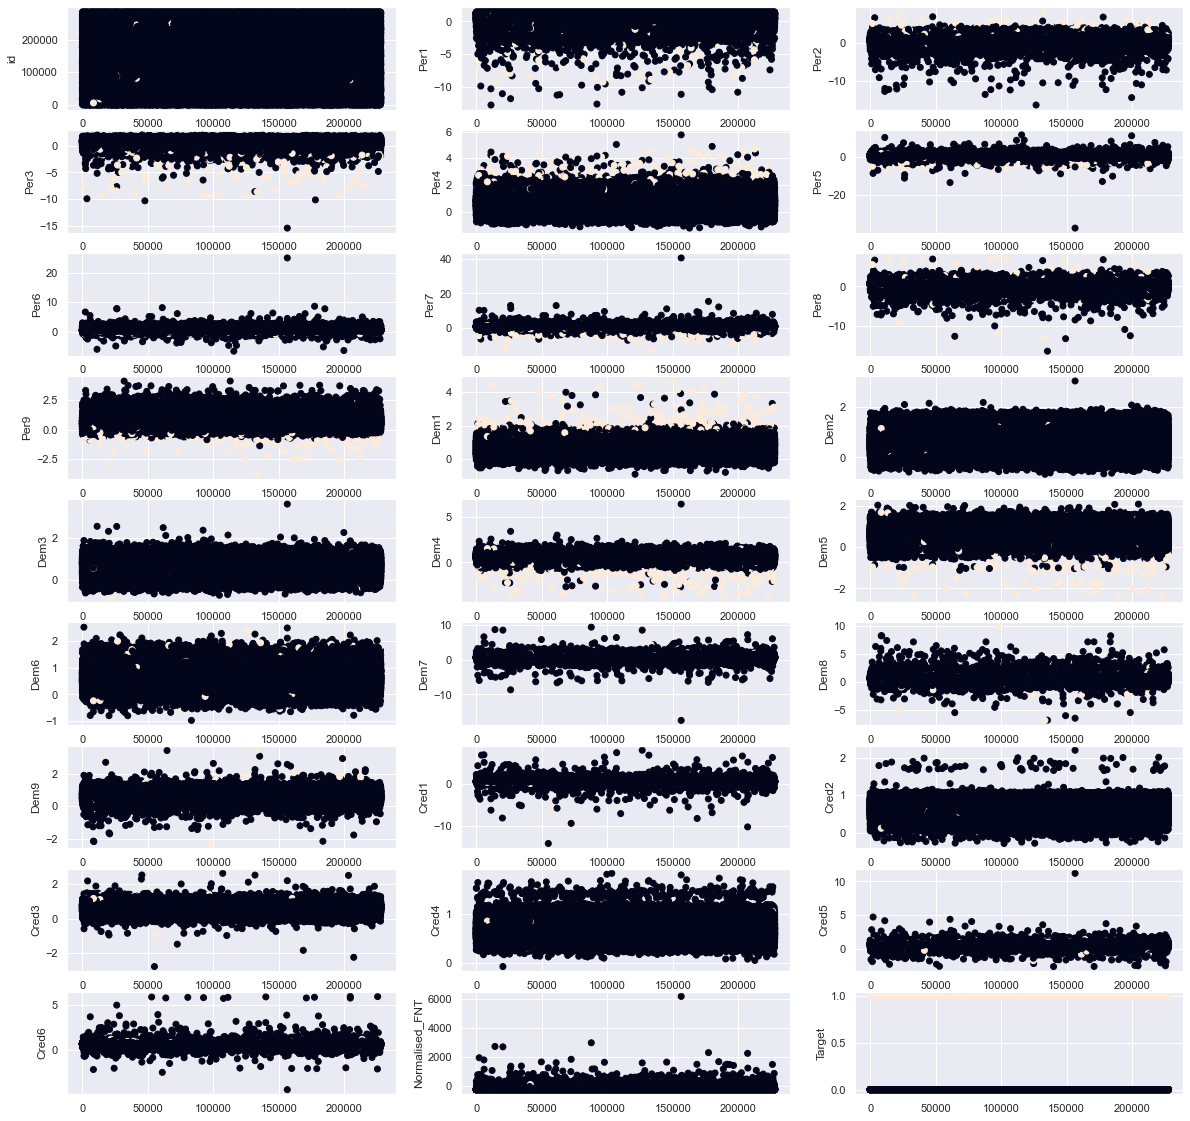

In [63]:
# Visualising the data

numeric_cols = train_df.select_dtypes(include = np.number)
column_names = list(numeric_cols.columns)
columns_index = 0

plot_rows = 9
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows, ncols = plot_cols, figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = train_df[column_names[columns_index]], x = train_df.index, c = train_df['Target'])
        ax[row_count][col_count].set_ylabel(column_names[columns_index])
        columns_index += 1

In [62]:
# Visualising the data

numeric_cols = train_df.select_dtypes(include = np.number)

geniune_trans = numeric_cols.loc[numeric_cols['Target'] == 0, :]
fraud_trans = 

column_names = list(numeric_cols.columns)
columns_index = 0

plot_rows = 9
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows, ncols = plot_cols, figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = train_df[column_names[columns_index]], x = train_df.index, c = train_df['Target'])
        ax[row_count][col_count].set_ylabel(column_names[columns_index])
        columns_index += 1

Index(['id', 'Per1', 'Per2', 'Per3', 'Per4', 'Per5', 'Per6', 'Per7', 'Per8',
       'Per9', 'Dem1', 'Dem2', 'Dem3', 'Dem4', 'Dem5', 'Dem6', 'Dem7', 'Dem8',
       'Dem9', 'Cred1', 'Cred2', 'Cred3', 'Cred4', 'Cred5', 'Cred6',
       'Normalised_FNT', 'Target'],
      dtype='object')
27


In [12]:
# Checking for data imbalance in training dataset

# dataset_df['Target'].value_counts()

In [13]:
# Checking percentage of minority class

# print(394/(394+227451)*100,"%")

#### We can see a clear data imbalance

In [14]:
# Balancing the dataset by oversampling (Random Oversampler technique)
# Spliting x and y (DV and IDV) first

# features_df = dataset_df.iloc[:,:-1]
# target_df = dataset_df.iloc[:,-1]

In [15]:
# features_df.columns

In [16]:
# target_df.head()

In [17]:
# Split train and test before sampling

# train_features, val_features, train_target, val_target = train_test_split(features_df, target_df, train_size = 0.7, random_state = 1, stratify = target_df)

In [19]:
# print(train_features.shape, val_features.shape, train_target.shape, val_target.shape)

In [ ]:
# Checking if the imbalance percentage is stratified properly

# print("Traing target counts",train_target.value_counts())
# print("Validation target counts",val_target.value_counts())

In [ ]:
# print("Train targets minority class : ", (276/(276+159215)*100), "%")
# print("Validation targets minority class : ", (118/(118+68236)*100), "%")

#### Minority class before and after train test spllt is 0.17%

In [ ]:
# Oversampling

# over = RandomOverSampler()
# over_train_features, over_train_target = over.fit_resample(train_features, train_target)
# over_val_features, over_val_target = over.fit_resample(val_features, val_target)

In [ ]:
# After oversampling

# print("Shape : ", over_train_features.shape, over_train_target.shape, over_val_features.shape, over_val_target.shape)
# print("Value counts : ", over_train_target.value_counts(), over_val_target.value_counts())

In [ ]:
# over_train_features.info()

In [ ]:
# Encoding
# Only one column is of type object, encoding needed for 'Group' column only

# Converting object type to integer

# over_train_features['Group'] = over_train_features['Group'].astype('category')
# over_train_features['Group'] = over_train_features['Group'].cat.codes

In [ ]:
# Checking for unique values 

# over_train_features['Group'].nunique()

In [ ]:
# over_train_features['Group'][0]

In [ ]:
# over_train_features['Group'][1]

In [ ]:
# Checking whether Group is a significant variable or not
# check p-value

# model = ols('Target ~ Group', data = [over_train_features, over_train_target]).fit()
# anova_result = sm.stats.anova_lm(model, typ=2)
# print(anova_result)

#### Since p-value is greater that 0.05 the Group feature is not significant

In [ ]:
# Droping the 'Group' column

